# Quantum dataset - logistic

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "ds-quantum"

nb_devices_for_the_run = 100


# Data preparation

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/quantum/phy_train.csv', sep="\t", header = None)
columns_with_missing_values = []
for col in range(1, len(data.columns)):
    if (not data[data[col] == 999].empty) or (not data[data[col] == 9999].empty):
        columns_with_missing_values.append(col)
print("Following columns has missing values :", columns_with_missing_values)
data.drop(data.columns[columns_with_missing_values],axis=1,inplace=True)
print("This columns has been removed.")
data = data.rename(columns={ 0: "ID", 1: "state", 80: "nothing" })
data = data.drop(['ID', 'nothing'], axis=1)
data.head()

Following columns has missing values : [21, 22, 23, 30, 45, 46, 47, 56]
This columns has been removed.


,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,0,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [3]:
dim_notebook = len(data.columns) - 1 # We don't count as dimension the labels
print("There is " + str(dim_notebook) + " dimensions.")

There is 70 dimensions.


In [4]:
# Showing that there is empty columns (with null std).
small_std = []
std_data = data.std()
for i in range(len(data.columns)):
    if std_data.iloc[i] < 1e-5:
        small_std.append(i)
print(small_std)
data.iloc[:,small_std].describe()

[40, 41, 42, 43, 44]


,48,49,50,51,52
count,50000.0,50000.0,50000.0,50000.0,50000.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


In [5]:
# Removing columns with null std
data = data.loc[:, (data.std() > 1e-6)]
dim_notebook = len(data.columns) - 1
print("Now, there is " + str(dim_notebook) + " dimensions.")

Now, there is 65 dimensions.


In [6]:
data = data.replace({'state': {0: -1}})
data.head()

,state,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.876238,...,-1.0,-0.036906,-0.000724,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,-1,0.920167,0.817883,-0.646473,-1.0,0.000000,0.0,0.000000,0.0,0.401383,...,-1.0,-0.999927,-0.012102,0.920167,0.817883,-0.646473,-1.0,1.0,0.302235,0.950770
2,1,0.868397,0.178202,0.150828,-1.0,0.000000,0.0,0.000000,0.0,0.773496,...,1.0,0.908824,0.550843,0.868397,0.178202,0.150828,-1.0,1.0,0.001421,0.882853
3,-1,0.000000,0.000000,0.000000,0.0,1.577894,0.0,-0.369792,-1.0,1.417021,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,-1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.105217,...,1.0,0.000005,0.400702,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000


In [7]:
data['state'].value_counts()

-1    25139
 1    24861
Name: state, dtype: int64

In [8]:
#Separing features and labels
X_data = data.loc[:, data.columns != "state"]
Y_data = data.loc[:, data.columns == "state"]

#Data normalisation
X_scaled = scale(X_data)
Y_scaled = Y_data

# Handling non-iid data
(All the transformations have been done on the DataFrame "data".)

There is 100 devices.
Number of points on device 0 : 605
Number of points on device 1 : 1431
Number of points on device 2 : 778
Number of points on device 3 : 459
Number of points on device 4 : 649
Number of points on device 5 : 761
Number of points on device 6 : 1072
Number of points on device 7 : 452
Number of points on device 8 : 374
Number of points on device 9 : 569
Number of points on device 10 : 344
Number of points on device 11 : 363
Number of points on device 12 : 265
Number of points on device 13 : 482
Number of points on device 14 : 422
Number of points on device 15 : 272
Number of points on device 16 : 758
Number of points on device 17 : 64
Number of points on device 18 : 241
Number of points on device 19 : 221
Number of points on device 20 : 348
Number of points on device 21 : 581
Number of points on device 22 : 791
Number of points on device 23 : 400
Number of points on device 24 : 377
Number of points on device 25 : 515
Number of points on device 26 : 332
Number of point

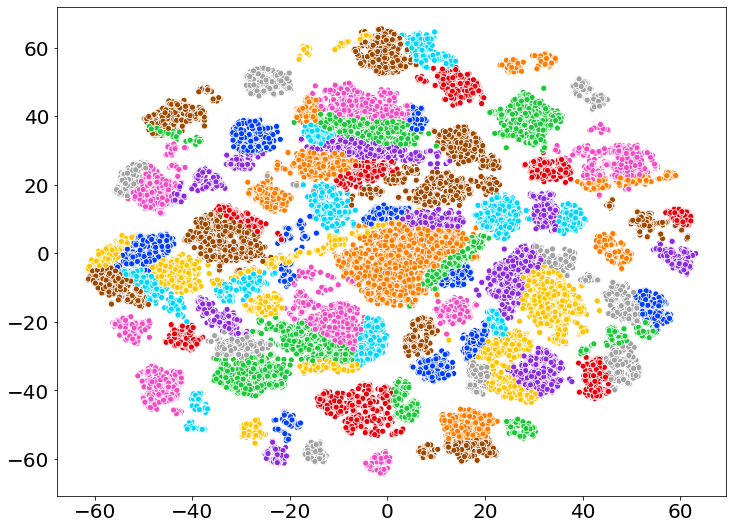

In [9]:
%%time
nb_cluster = nb_devices_for_the_run
embedded_data = pickle_loader("quantum-tsne")
# Finding cluster in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "state", nb_cluster, scale_Y=False)
dim_notebook = X[0].shape[1] - 1

In [10]:
from src.utils.DataClustering import rebalancing_clusters
X_r, Y_r = rebalancing_clusters(X, Y)

Changing : 
(64, 17)
(1431, 1)
Number of points on device 0 : 605
Number of points on device 1 : 716
Number of points on device 2 : 778
Number of points on device 3 : 459
Number of points on device 4 : 649
Number of points on device 5 : 761
Number of points on device 6 : 1072
Number of points on device 7 : 452
Number of points on device 8 : 374
Number of points on device 9 : 569
Number of points on device 10 : 344
Number of points on device 11 : 363
Number of points on device 12 : 265
Number of points on device 13 : 482
Number of points on device 14 : 422
Number of points on device 15 : 272
Number of points on device 16 : 758
Number of points on device 17 : 779
Number of points on device 18 : 241
Number of points on device 19 : 221
Number of points on device 20 : 348
Number of points on device 21 : 581
Number of points on device 22 : 791
Number of points on device 23 : 400
Number of points on device 24 : 377
Number of points on device 25 : 515
Number of points on device 26 : 332
Number

CPU times: user 43min 23s, sys: 3min 28s, total: 46min 51s
Wall time: 30min 3s


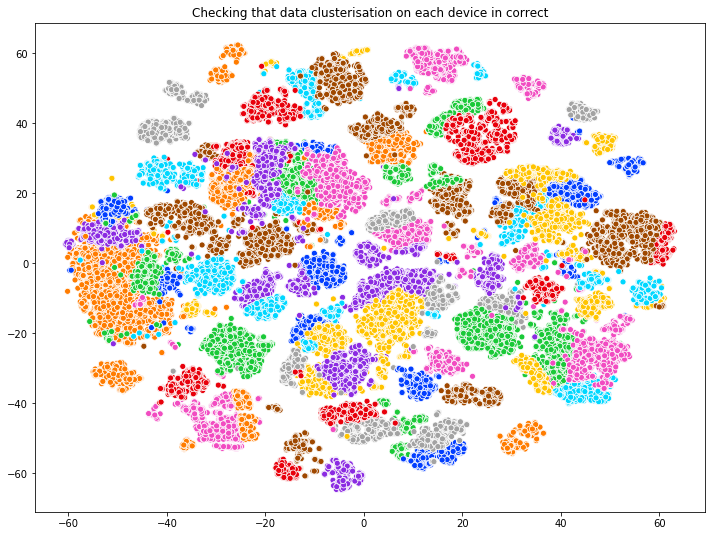

In [11]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [12]:
# Checking that data is unbalanced over devices.
print("Diplaying the ratio between state 1 and state -1.")
print("If data is iid, the ratio should be close to 0.5")
for y in Y:
    print("ratio of state 1 on this device: ", abs((y == 1).sum().item() / abs(y).sum().item()))

Diplaying the ratio between state 1 and state -1.
If data is iid, the ratio should be close to 0.5
ratio of state 1 on this device:  0.001652892561983471
ratio of state 1 on this device:  0.2292103424178896
ratio of state 1 on this device:  0.7789203084832905
ratio of state 1 on this device:  0.7058823529411765
ratio of state 1 on this device:  0.5577812018489985
ratio of state 1 on this device:  0.08409986859395532
ratio of state 1 on this device:  0.3908582089552239
ratio of state 1 on this device:  0.0022123893805309734
ratio of state 1 on this device:  0.12566844919786097
ratio of state 1 on this device:  1.0
ratio of state 1 on this device:  0.5348837209302325
ratio of state 1 on this device:  0.4820936639118457
ratio of state 1 on this device:  0.47924528301886793
ratio of state 1 on this device:  0.45228215767634855
ratio of state 1 on this device:  0.5213270142180095
ratio of state 1 on this device:  0.4632352941176471
ratio of state 1 on this device:  0.658311345646438
ratio o

In [13]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(LogisticModel, X_r, Y_r, nb_devices_for_the_run)

In [14]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_cluster,
                                                nb_epoch=20000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
    4000 | 5.3838e-01
    8000 | 5.3838e-01
   12000 | 5.3838e-01
   16000 | 5.3838e-01
Gradient Descent: execution time=3500.890 seconds
Final loss : 0.53838

CPU times: user 6h 35min 6s, sys: 51min 9s, total: 7h 26min 15s
Wall time: 58min 20s


## Batch size $= 100$, $\gamma = \frac{1}{L}$

In [15]:
def one_on_L(it, L, omega, N): return 1 / L

In [16]:
%%time
batch_size = 100
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=False, batch_size=batch_size, 
                                               nb_epoch=600, logs_file="{0}.txt".format(filename), 
                                               fraction_sampled_workers=0.5, step_formula=one_on_L)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-b{1}-s1".format(filename, batch_size))

100%|██████████| 5/5 [24:44<00:00, 296.93s/it]

CPU times: user 3h 24min 25s, sys: 24min 49s, total: 3h 49min 15s
Wall time: 24min 44s


### Without averaging

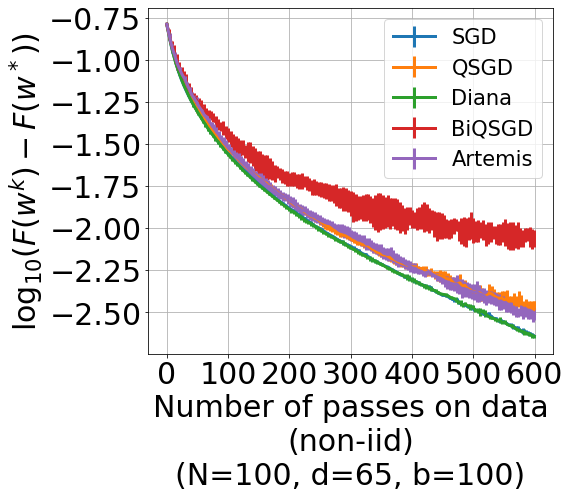

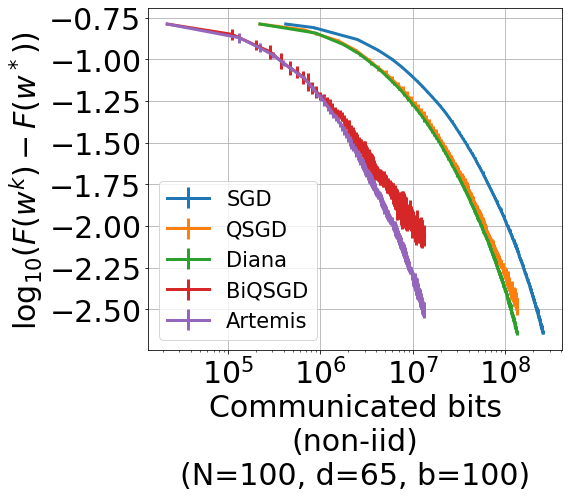

In [17]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s1".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

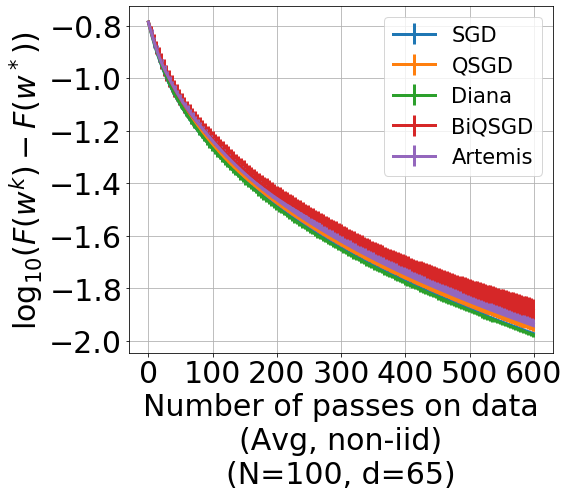

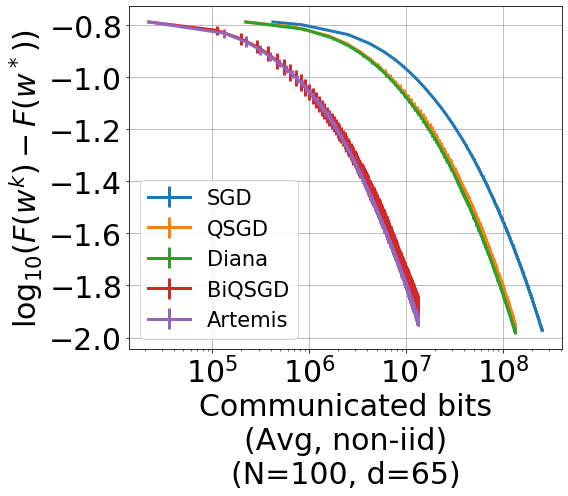

In [18]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s1".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits\n(Avg, non-iid)") 


## Batch size $= 100$, $\gamma = \frac{1}{2L}$

In [19]:
def one_on_2L(it, L, omega, N): return 1 / (2*L)

In [20]:
%%time
batch_size = 100
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=False, batch_size=batch_size, 
                                               nb_epoch=600, logs_file="{0}.txt".format(filename), 
                                               fraction_sampled_workers=0.5, step_formula=one_on_2L)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-b{1}-s2".format(filename, batch_size))

100%|██████████| 5/5 [21:35<00:00, 259.20s/it]

CPU times: user 3h 6min 11s, sys: 21min 37s, total: 3h 27min 49s
Wall time: 21min 36s


### Without averaging

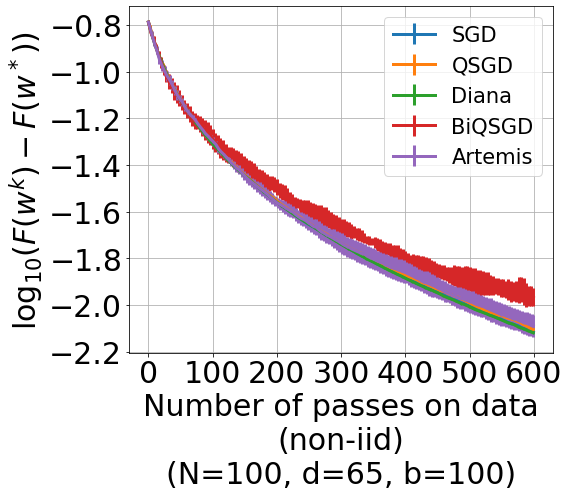

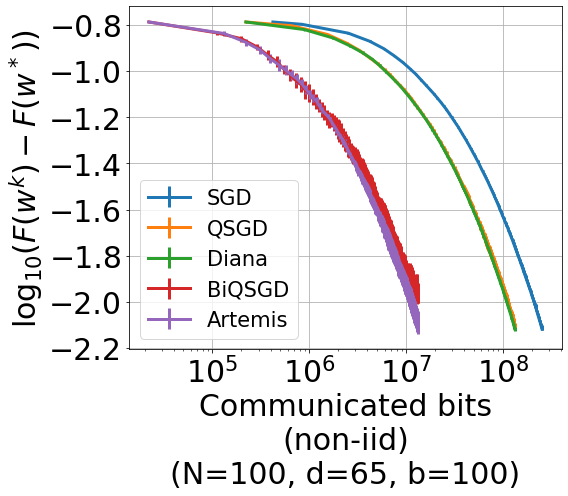

In [21]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s2".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits,  batch_size=batch_size,
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

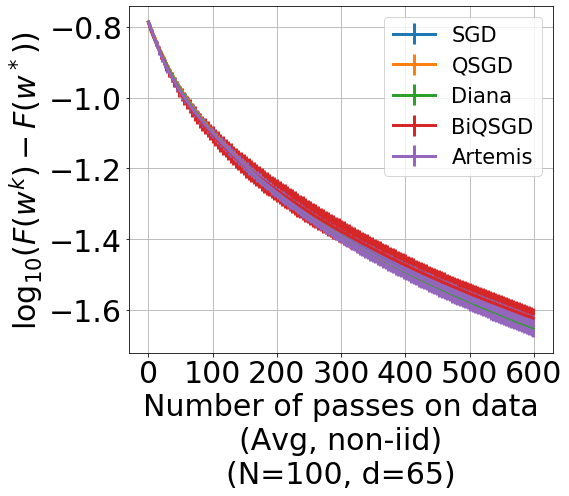

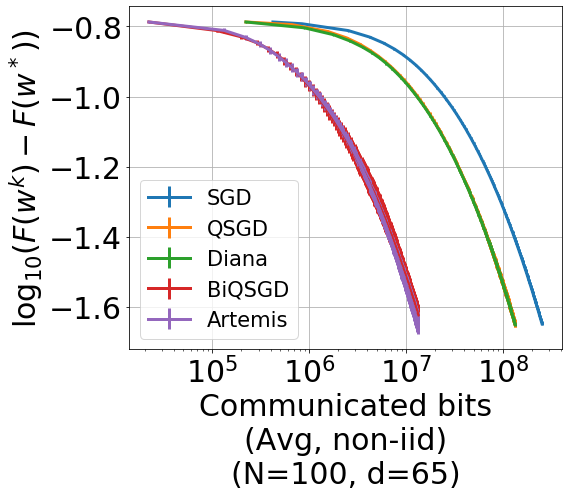

In [22]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-b{1}-s2".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits\n(Avg, non-iid)") 


## Full batch, $\gamma = \frac{1}{L}$

In [23]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, stochastic=False, 
                                               nb_epoch=600, logs_file="{0}.txt".format(filename), 
                                               fraction_sampled_workers=0.5, step_formula=one_on_L)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, "{0}-noniid-descent-full".format(filename))

100%|██████████| 5/5 [22:30<00:00, 270.18s/it]

CPU times: user 3h 15min 5s, sys: 22min 46s, total: 3h 37min 52s
Wall time: 22min 31s


### Without averaging

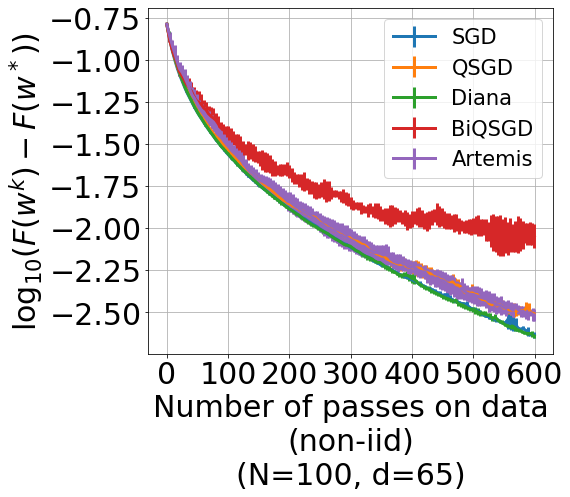

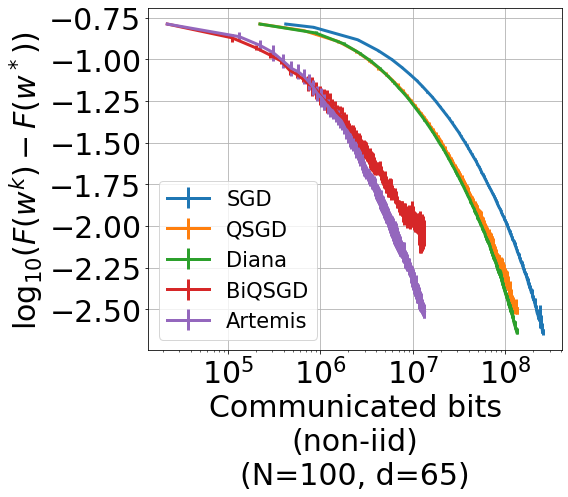

In [24]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-full".format(filename))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                x_points=res.X_number_of_bits, 
                x_legend="Communicated bits\n(non-iid)", all_error=res.get_std(obj)) 

### With averaging

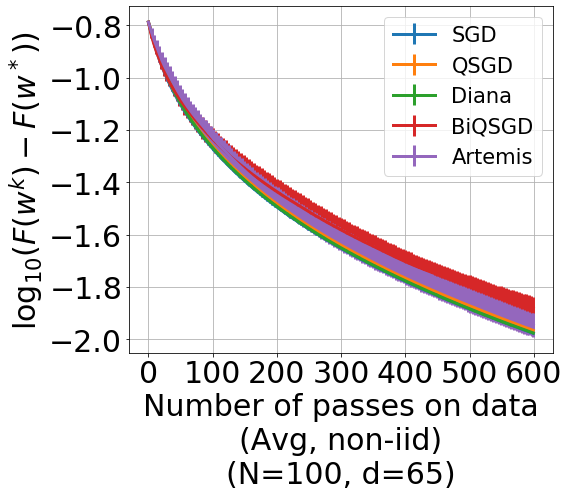

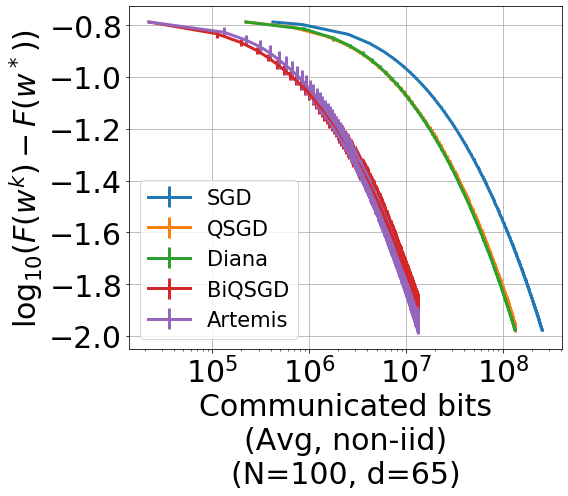

In [25]:
obj = pickle_loader("{0}-noniid-obj_min".format(filename))
res = pickle_loader("{0}-noniid-descent-full".format(filename))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=True), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits\n(Avg, non-iid)") 
